In [203]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import data_cleaner as dc
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})
import importlib
importlib.reload(dc)
%matplotlib inline

In [160]:
df = pd.read_csv('data/df.csv', index_col=0).dropna()
df.columns = df.columns.str.lower()
df = df.rename(columns={'addr_pct_cd' : 'pct'})


engineer features

In [161]:
df['policy'] = (df.year < 2013).mul(1)
df['nonstop_arrests'] = df.arrests - df.stop_arrests
df['crimerate'] = df.cmplnts / df.population * 1000
df['nonstop_arrestrate'] = df.nonstop_arrests / df.population * 1000
df['stoprate'] = df.stops / df.population * 1000
df['stop_arrestrate'] = df.stop_arrests / df.population * 1000
df['arrestrate'] = df.arrests / df.population * 1000
df['normal_year'] = df.year - 2007

In [147]:
df

,year,pct,cmplnts,population,arrests,stops,stop_arrests,policy,nonstop_arrests,crimerate,nonstop_arrestrate,stoprate,stop_arrestrate,arrestrate,normal_year
2,2008.0,1.0,6614.0,66679.0,5008.0,2506.0,221.0,1,4787.0,99.191650,71.791719,37.583047,3.314387,75.106105,1.0
3,2009.0,1.0,6280.0,66679.0,5371.0,2585.0,238.0,1,5133.0,94.182576,76.980759,38.767828,3.569340,80.550098,2.0
4,2010.0,1.0,5895.0,66679.0,4950.0,2446.0,260.0,1,4690.0,88.408644,70.336988,36.683214,3.899279,74.236266,3.0
5,2011.0,1.0,5955.0,66679.0,5583.0,3626.0,215.0,1,5368.0,89.308478,80.505107,54.379940,3.224403,83.729510,4.0
6,2012.0,1.0,6287.0,66679.0,5479.0,3053.0,189.0,1,5290.0,94.287557,79.335323,45.786529,2.834476,82.169799,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,2014.0,123.0,2859.0,98032.0,1555.0,321.0,70.0,0,1485.0,29.163946,15.148115,3.274441,0.714053,15.862167,7.0
984,2015.0,123.0,2732.0,98032.0,1439.0,127.0,30.0,0,1409.0,27.868451,14.372858,1.295495,0.306023,14.678880,8.0
985,2016.0,123.0,2648.0,98032.0,1568.0,90.0,32.0,0,1536.0,27.011588,15.668353,0.918068,0.326424,15.994777,9.0
986,2017.0,123.0,2549.0,98032.0,1602.0,62.0,23.0,0,1579.0,26.001714,16.106985,0.632447,0.234617,16.341603,10.0


Note that two of the precincts (22 in particular) have outlier crimerates (because they have low residential population).

In [287]:
df.groupby(by='pct').mean().crimerate.sort_values(ascending=False)

pct
22.0     16309.090909
14.0       545.269655
18.0       148.337217
25.0       143.429443
41.0       133.555244
             ...     
123.0       31.366381
112.0       30.757534
19.0        30.252103
111.0       25.841290
66.0        24.518787
Name: crimerate, Length: 76, dtype: float64

Drop the outlier precincts, Central Park and Midtown South.

In [292]:
df = df[~df.pct.isin([22, 14])]

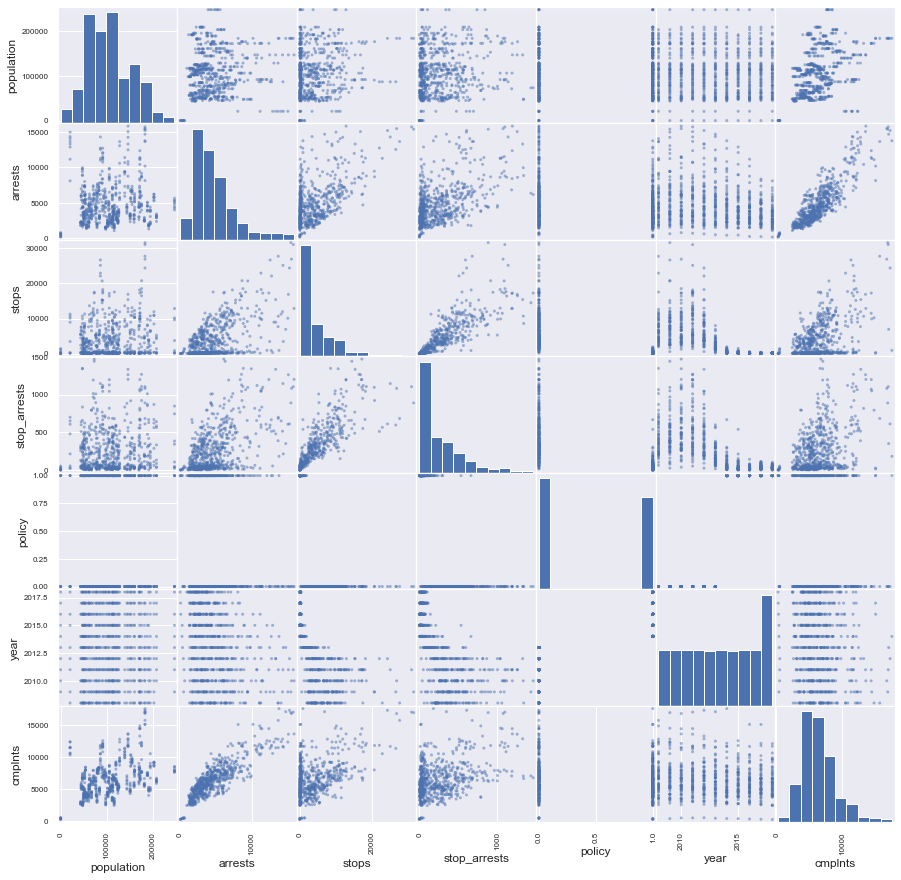

In [64]:
sns.set(rc={'figure.figsize':(15,15)})
pd.plotting.scatter_matrix(train);


As we can see, there is extremely high correlation between complaints and arrests, and there is a very high correlation between stops and stop arrests. Other data is well correlated as well.

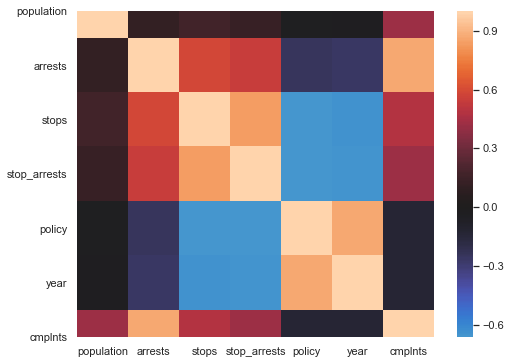

In [71]:
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(train.corr(), center=0);

## Basic linear model

In [250]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import importlib
import data_modeler as dm
importlib.reload(dm)

<module 'data_modeler' from '/Users/brad/Documents/Scripts/flatiron/fis-mod4-project/data_modeler.py'>

Look at base features:

In [391]:
x_vars = ['population', 'arrests', 'stops', 'stop_arrests', 'policy', 'normal_year']
results = dm.run_ols(df, x_vars, 'cmplnts')
results['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cmplnts   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     651.8
Date:                Wed, 04 Dec 2019   Prob (F-statistic):          1.03e-269
Time:                        10:14:37   Log-Likelihood:                -5410.2
No. Observations:                 651   AIC:                         1.083e+04
Df Residuals:                     644   BIC:                         1.087e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -372.5590    253.970     -1.467      0.143    -871.269     126.151
population       0.0180      0.001     22.361      0.000       0.016       0.020
arrests          0.8759      0.020     44.164      0.000       0.837       0.915
stops           -0.0218      0.016     -1.361      0.174      -0.053       0.010
stop_arrests    -0.9427      0.266     -3.545      0.000      -1.465      -0.421
policy         696.2175    181.425      3.837      0.000     339.961    1052.474
normal_year    119.5683     24.788      4.824      0.000      70.894     168.242
==============================================================================
Omnibus:                       24.711   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.410
Skew:                           0.256   Prob(JB):                     2.27e-10
Kurtosis:                       4.172   Cond. No.                     9.38e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [392]:
x_vars = ['nonstop_arrestrate','stoprate','stop_arrestrate','policy','normal_year','population']
dm.run_ols(df, x_vars, 'crimerate')['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              crimerate   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     605.5
Date:                Wed, 04 Dec 2019   Prob (F-statistic):          6.45e-261
Time:                        10:15:12   Log-Likelihood:                -2493.3
No. Observations:                 651   AIC:                             5001.
Df Residuals:                     644   BIC:                             5032.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             26.8275      3.207      8.365      0.000      20.530      33.125
nonstop_arrestrate     0.8060      0.020     40.660      0.000       0.767       0.845
stoprate              -0.0075      0.019     -0.398      0.691      -0.045       0.030
stop_arrestrate       -0.3326      0.245     -1.356      0.176      -0.814       0.149
policy                 7.5576      2.012      3.756      0.000       3.606      11.509
normal_year            1.2090      0.282      4.280      0.000       0.654       1.764
population         -7.969e-05   1.09e-05     -7.303      0.000      -0.000   -5.83e-05
==============================================================================
Omnibus:                       92.463   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              443.775
Skew:                           0.530   Prob(JB):                     4.32e-97
Kurtosis:                       6.903   Cond. No.                     9.79e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.79e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [342]:
x_vars = ['population','nonstop_arrestrate']
results = dm.run_ols(df, x_vars, 'crimerate')
results['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              crimerate   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1698.
Date:                Tue, 03 Dec 2019   Prob (F-statistic):          2.12e-258
Time:                        23:09:56   Log-Likelihood:                -2511.2
No. Observations:                 651   AIC:                             5028.
Df Residuals:                     648   BIC:                             5042.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             39.1806      1.800     21.769      0.000      35.646      42.715
population          -8.86e-05   1.08e-05     -8.172      0.000      -0.000   -6.73e-05
nonstop_arrestrate     0.7625      0.017     45.208      0.000       0.729       0.796
==============================================================================
Omnibus:                      121.903   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              566.990
Skew:                           0.760   Prob(JB):                    7.58e-124
Kurtosis:                       7.312   Cond. No.                     4.81e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [379]:
x_vars = ['nonstop_arrestrate']
results = dm.run_ols(df, x_vars, 'crimerate')
results['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              crimerate   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     3194.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):          7.35e-253
Time:                        09:58:10   Log-Likelihood:                -2536.6
No. Observations:                 651   AIC:                             5077.
Df Residuals:                     649   BIC:                             5086.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             26.6886      0.835     31.946      0.000      25.048      28.329
nonstop_arrestrate     0.8238      0.015     56.520      0.000       0.795       0.852
==============================================================================
Omnibus:                      137.360   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              597.770
Skew:                           0.892   Prob(JB):                    1.57e-130
Kurtosis:                       7.343   Cond. No.                         102.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [335]:
X_train = results['data']['X_train'].copy()
X_test = results['data']['X_test'].copy()
y_train = results['data']['y_train']
y_test = results['data']['y_test']
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 972893.4381786116
Test Mean Squared Error: 1108022.0815390856


In [323]:
linreg.intercept_, linreg.coef_[0], linreg.score(X_train,y_train), linreg.score(X_test, y_test)

(-360.78659094890736,
 0.01831168471879306,
 0.8601905796684512,
 0.8071084449717738)

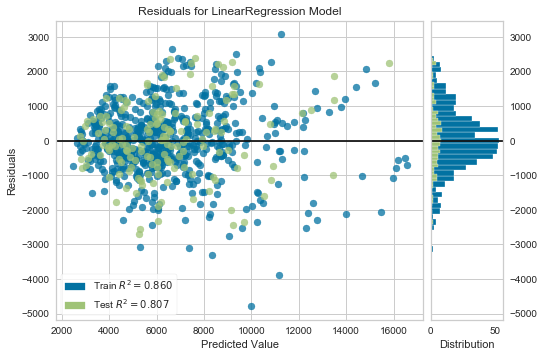

In [336]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

In [368]:
x_vars = ['nonstop_arrestrate','stoprate','stop_arrestrate','policy','normal_year']
results = dm.run_ols(df, x_vars, 'crimerate')
X_train = results['data']['X_train'].copy()
X_test = results['data']['X_test'].copy()
y_train = results['data']['y_train']
y_test = results['data']['y_test']
results['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              crimerate   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     643.8
Date:                Wed, 04 Dec 2019   Prob (F-statistic):          6.12e-248
Time:                        09:57:41   Log-Likelihood:                -2521.0
No. Observations:                 651   AIC:                             5054.
Df Residuals:                     645   BIC:                             5081.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             14.3717      2.747      5.232      0.000       8.978      19.766
nonstop_arrestrate     0.8321      0.018     45.261      0.000       0.796       0.868
stoprate              -0.0201      0.019     -1.056      0.291      -0.057       0.017
stop_arrestrate        0.1225      0.272      0.451      0.652      -0.411       0.656
policy                 7.6482      2.108      3.627      0.000       3.508      11.789
normal_year            1.4789      0.293      5.050      0.000       0.904       2.054
==============================================================================
Omnibus:                       56.837   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.855
Skew:                           0.404   Prob(JB):                     3.55e-37
Kurtosis:                       5.353   Cond. No.                         585.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [380]:
from sklearn import metrics

def run_model(model, X_train, X_test, y_train, y_test):
    
    print('Training R^2 :', model.score(X_train, y_train))
    y_pred_train = model.predict(X_train)
    print('Training Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
    print('\n----------------\n')
    print('Testing R^2 :', model.score(X_test, y_test))
    y_pred_test = model.predict(X_test)
    print('Testing Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
    
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression

rfe = RFECV(LinearRegression(), cv=5)
X_rfe_train = rfe.fit_transform(X_train, y_train)
X_rfe_test = rfe.transform(X_test)
lm = LinearRegression().fit(X_rfe_train, y_train)
run_model(lm, X_rfe_train, X_rfe_test, y_train, y_test)
print ('The optimal number of features is: ', rfe.n_features_)

Training R^2 : 0.8327685222345668
Training Root Mean Square Error 11.640572337903485

----------------

Testing R^2 : 0.8190432860431288
Testing Root Mean Square Error 12.726194347669717
The optimal number of features is:  3


## VIF


In [382]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [393]:
x_vars = ['nonstop_arrestrate','stoprate','stop_arrestrate','policy','normal_year','population']
results = dm.run_ols(df, x_vars, 'crimerate')
X_train = results['data']['X_train'].copy()
X_test = results['data']['X_test'].copy()
y_train = results['data']['y_train']
y_test = results['data']['y_test']

vif = [variance_inflation_factor(X_train.values, i) for i in range(1, X_train.shape[1])]
print(X_train.columns.to_list())
list(vif)

['nonstop_arrestrate', 'stoprate', 'stop_arrestrate', 'policy', 'normal_year', 'population']


[7.745466574333727,
 6.608651006694013,
 4.7747958404574575,
 6.252860679177004,
 5.987601633681862]

In [ ]:

x_vars = ['nonstop_arrestrate','stoprate',]
vif = [variance_inflation_factor(X_train.values, i) for i in range(1, X_train.shape[1])]
print(X_train.columns.to_list())
list(vif)

One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

## PCA to reduce multicollinearity

In [303]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [344]:
X_train = results['data']['X_train'].copy()
X_test = results['data']['X_test'].copy()
y_train = results['data']['y_train']
y_test = results['data']['y_test']
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [345]:
pca = PCA('mle')
pca.fit(X_train)
pca.n_components_

5

In [346]:
pca.explained_variance_ratio_.sum()

0.9820583200929763

In [347]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [348]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 1061446.6964280042
Test Mean Squared Error: 1220601.3755058208


In [329]:
linreg.intercept_, linreg.coef_[0], linreg.score(X_train,y_train), linreg.score(X_test, y_test)

(6505.755760368664, 611.4049683248925, 0.8469433025017485, 0.7836269841368444)

Text(0.5, 1.0, 'Linear Regression')

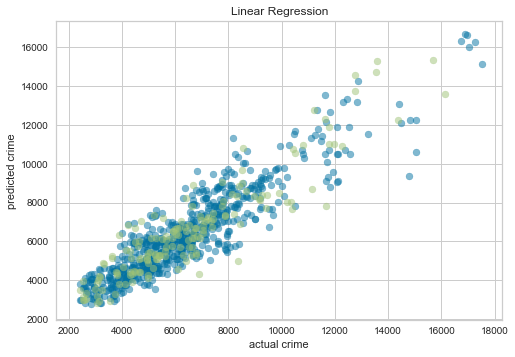

In [354]:
plt.scatter(y_train, linreg.predict(X_train), alpha=0.5)
plt.scatter(y_test, linreg.predict(X_test), alpha=0.5)
plt.xlabel('actual crime')
plt.ylabel('predicted crime')
plt.title('Linear Regression')

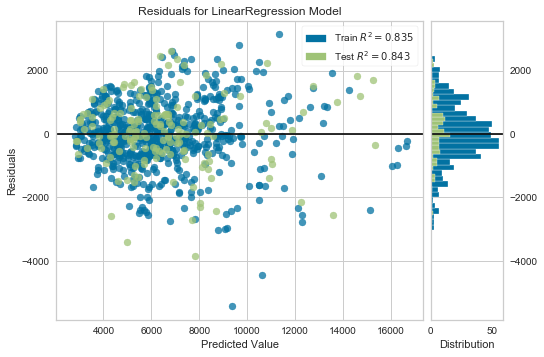

In [350]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

## Cross validation

In [ ]:
https://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html

## Try interaction terms

In [26]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
poly.fit_transform(X)
clf = linear_model.LinearRegression()
clf.fit(X, y)

,year,pct,cmplnts,population,arrests,stops,stop_arrests
2,2008.0,1.0,6614.0,66679.0,5008.0,2506.0,221.0
3,2009.0,1.0,6280.0,66679.0,5371.0,2585.0,238.0
4,2010.0,1.0,5895.0,66679.0,4950.0,2446.0,260.0
5,2011.0,1.0,5955.0,66679.0,5583.0,3626.0,215.0
6,2012.0,1.0,6287.0,66679.0,5479.0,3053.0,189.0
...,...,...,...,...,...,...,...
983,2014.0,123.0,2859.0,98032.0,1555.0,321.0,70.0
984,2015.0,123.0,2732.0,98032.0,1439.0,127.0,30.0
985,2016.0,123.0,2648.0,98032.0,1568.0,90.0,32.0
986,2017.0,123.0,2549.0,98032.0,1602.0,62.0,23.0
